In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")

Dispositivo usado: cpu


In [2]:
path = "./MNIST/sign_mnist_train/sign_mnist_train.csv"
train_path = "./MNIST/sign_mnist_test/sign_mnist_test.csv"
# Convertirlas en un data frame
train_data = pd.read_csv(path)
test_data = pd.read_csv(train_path)
# Separar las etiquetas de las imágenes
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
# Numero de clases
num_clases = train_data['label'].nunique()
print(f'Número de clases: {num_clases}')

Número de clases: 24


In [4]:
# Separar etiquetas e imágenes
y_train = train_data['label'].values
y_test = test_data['label'].values
x_train = train_data.drop(columns=['label']).values
x_test = test_data.drop(columns=['label']).values


In [5]:
from sklearn.preprocessing import LabelEncoder

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Ajustar y transformar las etiquetas de entrenamiento
y_train = label_encoder.fit_transform(y_train)

# Transformar las etiquetas de prueba
y_test = label_encoder.transform(y_test)

# Verificar las formas
print(len(y_train), len(y_test))
print(y_train, y_test)

27455 7172
[ 3  6  2 ... 17 16 22] [6 5 9 ... 2 4 2]


In [7]:
# pasar de 1D a 2D con un canal
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
len(x_train), len(x_test)

(27455, 7172)

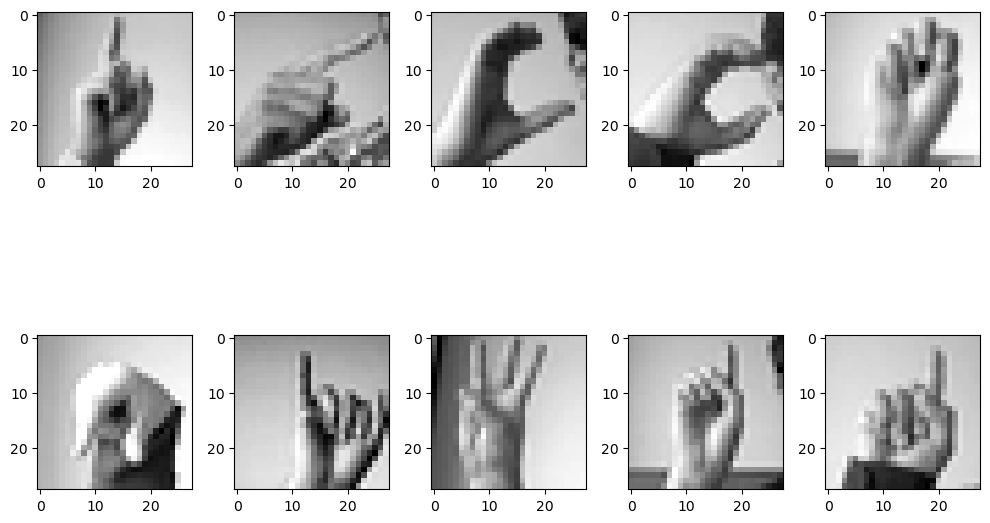

In [8]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout() 

In [10]:
from PIL import Image
# Definir transformaciones para crear el dataset
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # Convierte a float tensor y normaliza [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normaliza a [-1, 1]
])

class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        super().__init__()
        self.data = data  # Array NumPy con forma (N, 28, 28, 1)
        self.labels = labels  # Array de índices de clase (0-23)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convertir a entero de 8 bits sin signo y reestructurar
        imagen = self.data[idx].astype(np.uint8).reshape(28, 28, 1)
        
        # Convertir a imagen PIL en escala de grises
        imagen = Image.fromarray(imagen.squeeze(), mode='L')
        
        if self.transform:
            imagen = self.transform(imagen)
        etiqueta = self.labels[idx]
        return imagen, etiqueta

# Crear el dataset con transformaciones
dataset = MNISTDataset(x_train, y_train, transform=transform)
print(dataset.data.shape)  # Verificar la forma del dataset

(27455, 28, 28, 1)


In [11]:
train_data, val_data = random_split(dataset, [26000, 1455])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [12]:
print(len(dataset))
len(train_loader), len(val_loader)

27455


(407, 23)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
tensor(8)
tensor(12)
tensor(9)
tensor(15)
tensor(23)


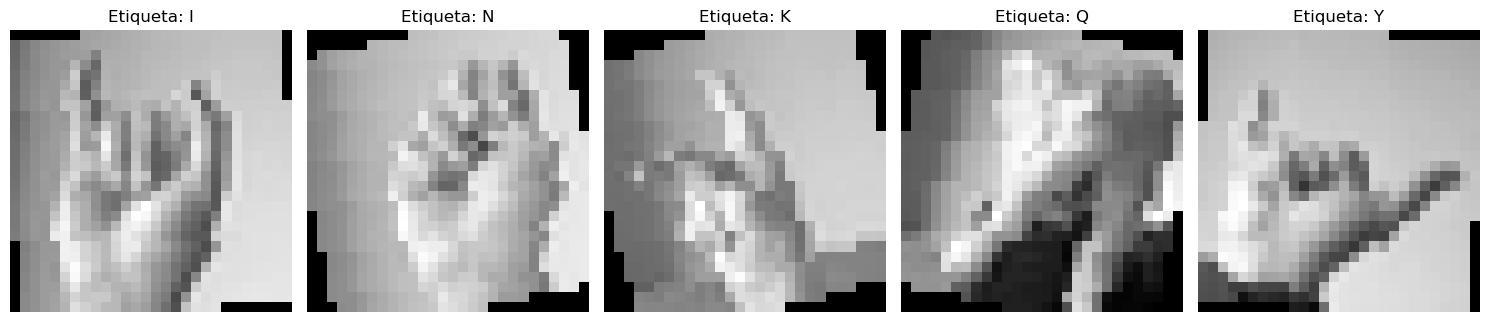

In [14]:
# Función para visualizar imágenes del DataLoader
def visualize_mnist(loader, classes, n_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Configurar la cuadrícula de la visualización
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images): 
        # Eliminar la dimensión del canal y convertir a NumPy
        img = images[i].squeeze().numpy()  # Forma: [28, 28]
        axes[i].imshow(img, cmap='gray')     
        
        # Convertir etiqueta one-hot a índice
        class_idx = labels[i]
        class_name = classes[class_idx]
        print(class_idx)
        
        axes[i].set_title(f"Etiqueta: {class_name}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Definir nombres de clases: A-Z sin J y Z
classes = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']]
print(classes)
# Llamar a la función de visualización
visualize_mnist(train_loader, classes=classes, n_images=5)

In [16]:
class MLP(nn.Module):
    def __init__(self, hidden_sizes, output_size):
        super(MLP, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1), # 64x64x3 -> 62x62x6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 62x62x6 -> 30x30x6
            
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=4, stride=1),  # 30x30x6 -> 27x27x12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),  # 27x27x12 -> 12x12x12
            
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=2, stride=1),  # 12x12x12 -> 11x11x12
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # 11x11x12 -> 1x1x12
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(12, hidden_sizes[0]),
            nn.ReLU(),
            #nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            #nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

# Instanciar el modelo con Dropout
hidden_sizes = [100, 30]
output_size = 24 # Número de clases
dropout_rate = 0.5
model = MLP(hidden_sizes, output_size).to(device)
print(model)

MLP(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 12, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=24, bias=True)
  )
)


In [18]:
# Cálculo del número total de parámetros
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"El modelo tiene un total de {total_params:,} parámetros entrenables.")

count_parameters(model)
# Función de pérdida
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1)#, weight_decay=0.1)

El modelo tiene un total de 6,886 parámetros entrenables.


In [19]:
# Ciclo de entrenamiento y validación
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

all_targets = []
all_predictions = []
best_val_accuracy = 0
best_model_weights = None
best_epoch = 0


for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()  # Modo entrenamiento
    train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)  # Aplanar las imágenes
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Acumular la pérdida
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Predicción más probable
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # --- Validación ---
    model.eval()  # Modo evaluación
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No se calculan gradientes
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Acumular la pérdida
            val_loss += loss.item()

            # Calcular la precisión
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
            
            # Guardar las etiquetas y predicciones para métricas adicionales
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    

    #########
    # Guardar los pesos del mejor modelo basado en la precisión de validación
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()
        best_epoch = epoch + 1


    # Calcular Recall y F1-score
    # Asumiendo que es una clasificación multiclase
    val_recall = recall_score(all_targets, all_predictions, average='macro')
    val_f1 = f1_score(all_targets, all_predictions, average='macro')

    # --- Imprimir resultados por época ---
    print(f"Época {epoch + 1}/{epochs}")
    print(f"  Entrenamiento -> Pérdida: {train_losses[-1]:.4f}, Precisión: {train_accuracy:.2f}%")
    print(f"  Validación   -> Pérdida: {val_losses[-1]:.4f}, Precisión: {val_accuracy:.2f}%")

model = MLP(hidden_sizes, output_size).to(device)
model.load_state_dict(best_model_weights)
print(f"Mejor modelo en la época {best_epoch} con precisión de validación: {best_val_accuracy:.2f}%")

Época 1/20
  Entrenamiento -> Pérdida: 3.1760, Precisión: 4.63%
  Validación   -> Pérdida: 3.1702, Precisión: 5.98%
Época 2/20
  Entrenamiento -> Pérdida: 2.9735, Precisión: 9.42%
  Validación   -> Pérdida: 2.6781, Precisión: 17.11%
Época 3/20
  Entrenamiento -> Pérdida: 2.3101, Precisión: 22.98%
  Validación   -> Pérdida: 1.9631, Precisión: 30.17%
Época 4/20
  Entrenamiento -> Pérdida: 1.8637, Precisión: 34.97%
  Validación   -> Pérdida: 2.0689, Precisión: 30.24%
Época 5/20
  Entrenamiento -> Pérdida: 1.4415, Precisión: 50.03%
  Validación   -> Pérdida: 1.2474, Precisión: 56.15%
Época 6/20
  Entrenamiento -> Pérdida: 1.0241, Precisión: 63.97%
  Validación   -> Pérdida: 1.1479, Precisión: 61.37%
Época 7/20
  Entrenamiento -> Pérdida: 0.7974, Precisión: 71.76%
  Validación   -> Pérdida: 1.1212, Precisión: 64.74%
Época 8/20
  Entrenamiento -> Pérdida: 0.6674, Precisión: 76.64%
  Validación   -> Pérdida: 2.6240, Precisión: 54.36%
Época 9/20
  Entrenamiento -> Pérdida: 0.5381, Precisión: 8

Época 20/20
  Entrenamiento -> Pérdida: 0.1877, Precisión: 93.71%
  Validación   -> Pérdida: 0.2944, Precisión: 90.31%
  Recall de Validación: 0.65
  F1-score de Validación: 0.65


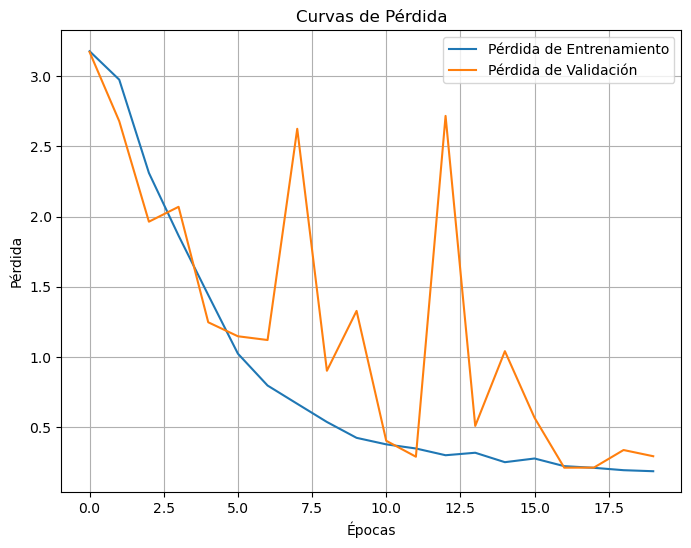

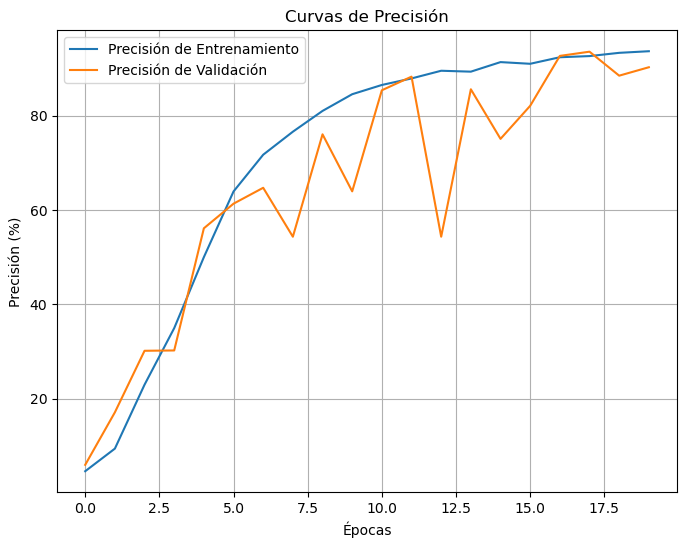

In [20]:

# --- Imprimir resultados por época ---
print(f"Época {epoch + 1}/{epochs}")
print(f"  Entrenamiento -> Pérdida: {train_losses[-1]:.4f}, Precisión: {train_accuracy:.2f}%")
print(f"  Validación   -> Pérdida: {val_losses[-1]:.4f}, Precisión: {val_accuracy:.2f}%")
print(f"  Recall de Validación: {val_recall:.2f}")
print(f"  F1-score de Validación: {val_f1:.2f}")

# Gráfica de la pérdida
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curvas de Pérdida')
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de la precisión
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Precisión de Entrenamiento')
plt.plot(val_accuracies, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión (%)')
plt.title('Curvas de Precisión')
plt.legend()
plt.grid(True)
plt.show()



In [22]:
def plot_predictions(model, loader, batch_ith=1):
    model.eval()
    data_iter = iter(loader)
    for i in range(batch_ith):
        inputs, targets = next(data_iter)
    inputs = inputs.to(device)  # No es necesario aplanar las imágenes para ASL
    targets = targets.to(device)

    outputs = model(inputs)  # Pasa las imágenes sin aplanar
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        img = inputs[i].cpu().permute(1, 2, 0).numpy()
        # Reescalar los valores de -1 a 1 para el rango 0 a 1
        axes[i].imshow(img, cmap='gray')  # Mostrar imagen en color
        # Obtener nombres de clases para predicción y etiqueta real
        predicted_class = classes[predicted[i]]  # Usa las clases del dataset
        true_class = classes[targets[i]]  # Usa las clases del dataset
        axes[i].set_title(f"Pred: {predicted_class}\nTrue: {true_class}")
        axes[i].axis("off")
    plt.show()

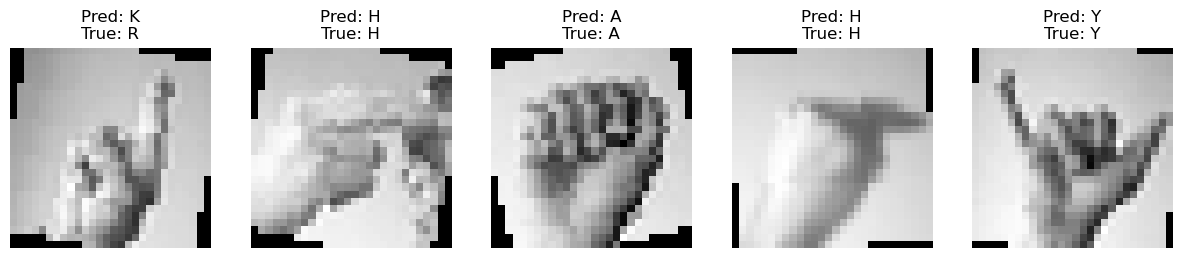

In [23]:
plot_predictions(model, val_loader, batch_ith = 5)

In [25]:
target_1 = []
predic_1 = []
model.eval()
for batch in val_loader:
    inputs, targets = batch
    inputs = inputs.to(device)  # No es necesario aplanar las imágenes para ASL
    targets = targets.to(device)
    target_1.extend(targets.cpu().numpy())

    outputs = model(inputs)  # Pasa las imágenes sin aplanar
    _, predicted = torch.max(outputs, 1)
    predic_1.extend(predicted.cpu().numpy())


In [26]:
classes = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']]
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(np.array(target_1) , np.array(predic_1), target_names = classes))

              precision    recall  f1-score   support

           A       0.96      0.97      0.96        67
           B       0.92      0.94      0.93        50
           C       1.00      0.98      0.99        60
           D       0.99      0.94      0.96        71
           E       0.90      0.96      0.93        57
           F       0.95      0.96      0.96        57
           G       0.96      0.92      0.94        53
           H       0.91      0.98      0.94        60
           I       1.00      0.83      0.91        48
           K       0.93      0.67      0.78        63
           L       0.96      0.95      0.96        84
           M       0.90      0.77      0.83        47
           N       0.82      1.00      0.90        67
           O       0.96      1.00      0.98        66
           P       0.62      1.00      0.77        56
           Q       0.98      0.80      0.88        71
           R       0.83      0.83      0.83        64
           S       0.98    

<Axes: >

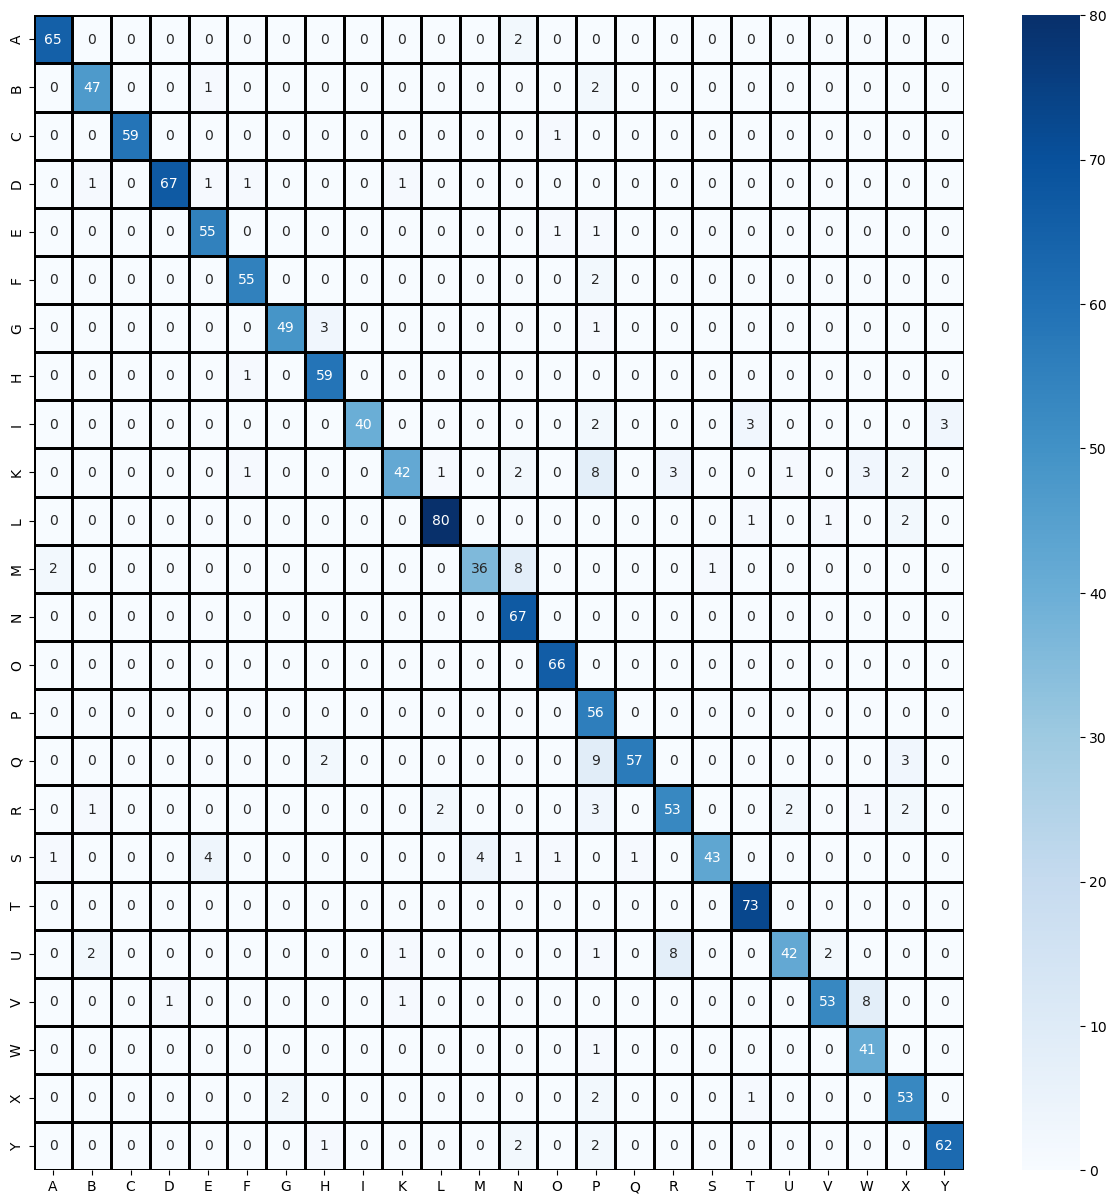

In [27]:
cm = confusion_matrix(np.array(target_1) , np.array(predic_1))
cm = pd.DataFrame(cm , index = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']] , columns = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']])
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [28]:
# Guardar los pesos del modelo
torch.save(model.state_dict(), "modelo.pth")
print("Pesos del modelo guardados")

Pesos del modelo guardados


##### *Nuestros Datos*

In [52]:

validation_dir = './imagenes/'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (1 canal)
    transforms.Resize((28, 28)),                  # Ajustar al tamaño requerido
    transforms.ToTensor(),                        # Convertir a tensor y escalar [0, 1]
    transforms.Normalize((0.5,), (0.5,))          # Normalizar a [-1, 1]
])



validation_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=15, shuffle=True)
# Obtener los nombres de las clases
class_names = validation_dataset.classes
print("Clases:", class_names)

Clases: ['A', 'E', 'I', 'O', 'U']


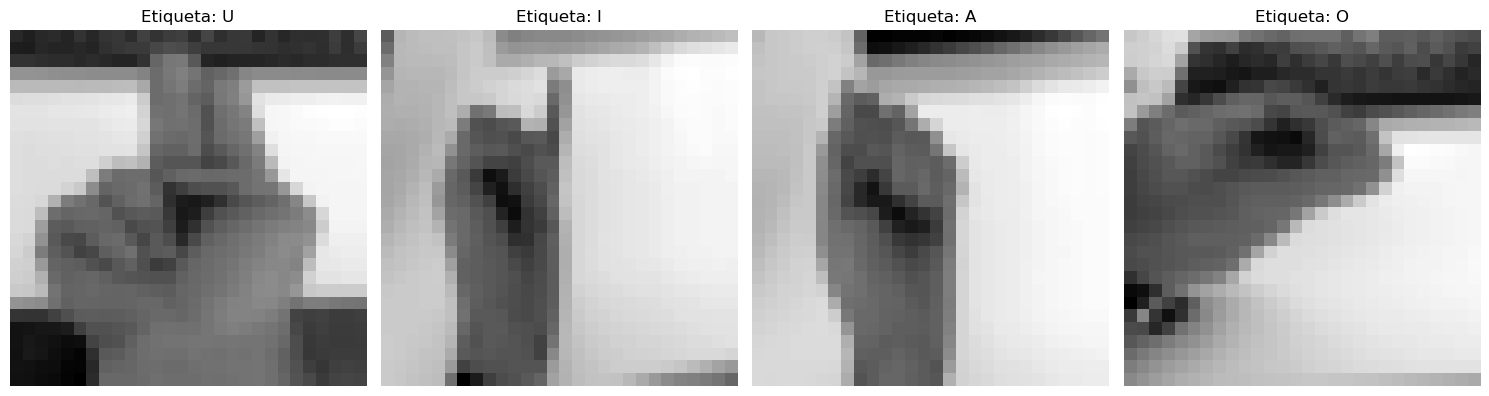

In [53]:
def visualize_validation(loader, class_names, n_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images): 
        img = images[i].permute(1, 2, 0).numpy()     
        img = (img * 0.5) + 0.5  # Desnormalizar
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Etiqueta: {class_names[labels[i]]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_validation(validation_loader, class_names, n_images=4)

In [54]:
# Cargar el modelo
hidden_sizes = [100, 30]
output_size = 24
model = MLP(hidden_sizes, output_size).to(device)
state = torch.load("modelo.pth")
model.load_state_dict(state)
model.eval()

C:\Users\overm\AppData\Local\Temp\ipykernel_17372\1244829334.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("modelo.pth")


MLP(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(12, 12, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=24, bias=True)
  )
)

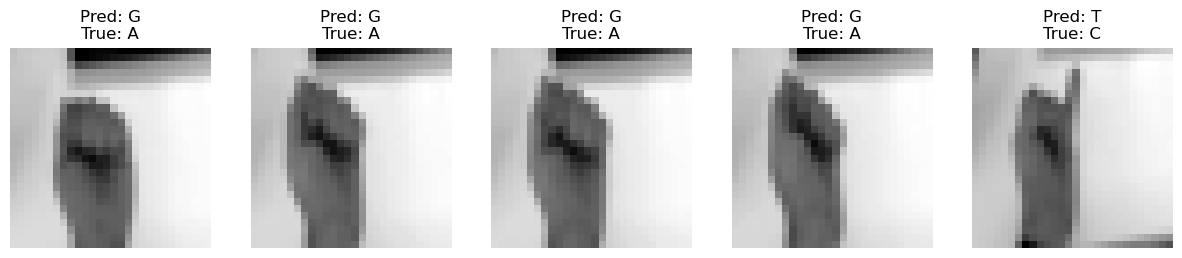

In [55]:
plot_predictions(model, validation_loader, batch_ith = 3)

In [56]:
target_2 = []
predic_2 = []
model.eval()
for batch in validation_loader:
    inputs, targets = batch
    inputs = inputs.to(device)  # No es necesario aplanar las imágenes para ASL
    targets = targets.to(device)
    target_2.extend(targets.cpu().numpy())

    outputs = model(inputs)  # Pasa las imágenes sin aplanar
    _, predicted = torch.max(outputs, 1)
    predic_2.extend(predicted.cpu().numpy())


In [30]:
classes = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']]
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(np.array(target_2) , np.array(predic_2), target_names = classes))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00       268
           B       0.00      0.00      0.00       204
           C       0.00      0.00      0.00       278
           D       0.00      0.00      0.00       245
           E       0.00      0.00      0.00       200
           F       0.31      0.29      0.30       181
           G       0.00      0.00      0.00       197
           H       0.07      1.00      0.13       247
           I       0.00      0.00      0.00       178
           K       0.67      0.27      0.39       237
           L       0.00      0.00      0.00       446
           M       0.00      0.00      0.00       263
           N       0.00      0.00      0.00       202
           O       0.00      0.00      0.00       182
           P       0.00      0.00      0.00       234
           Q       0.00      0.00      0.00       183
           R       0.00      0.00      0.00       190
           S       0.00    

c:\Users\overm\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\overm\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\overm\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

<Axes: >

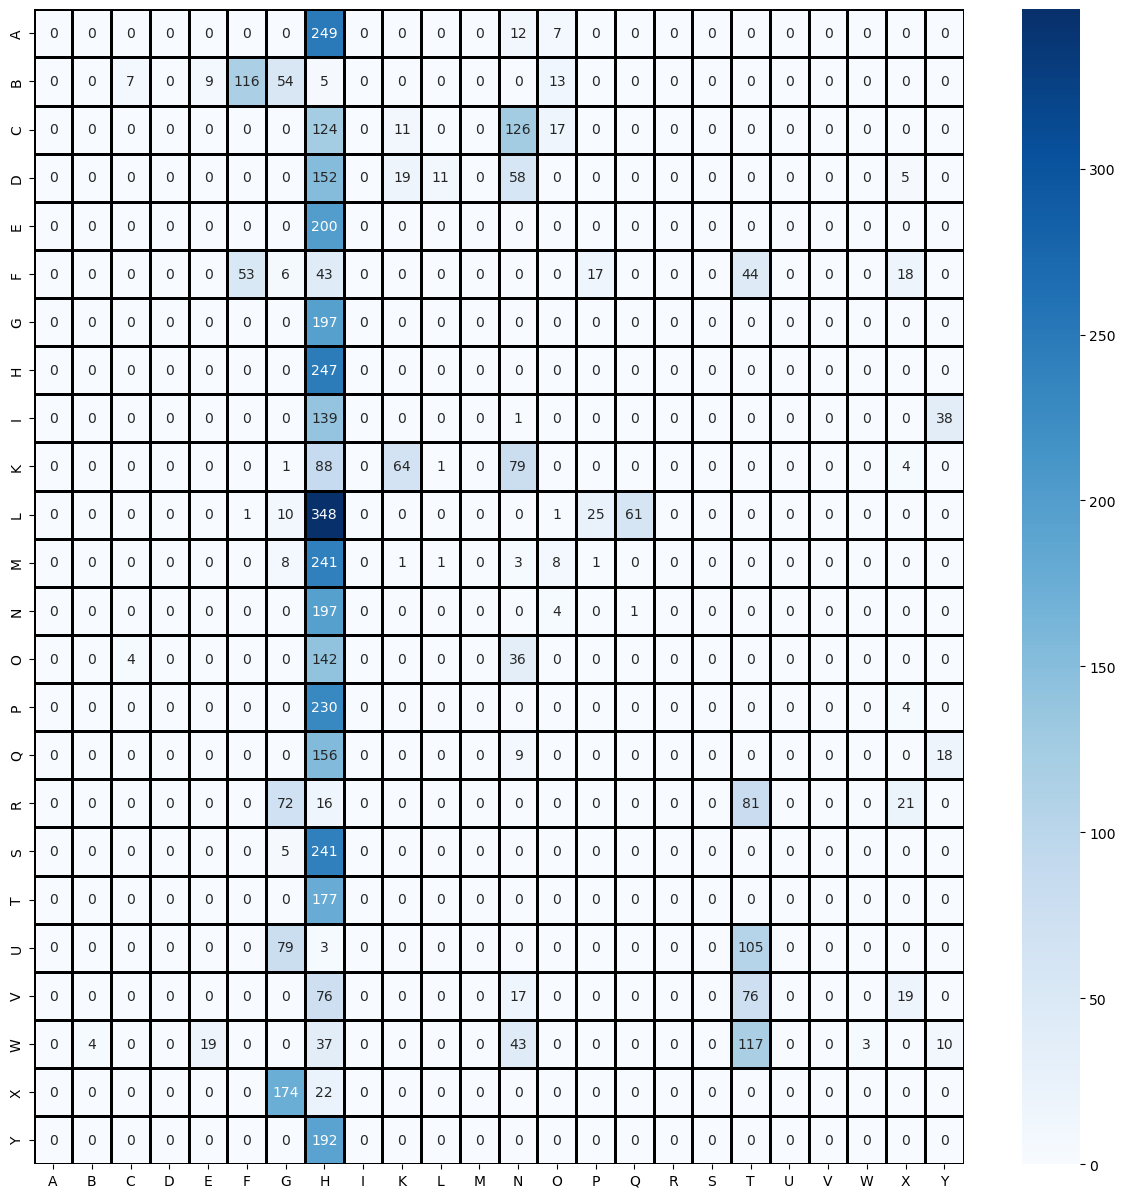

In [31]:
cm = confusion_matrix(np.array(target_2) , np.array(predic_2))
cm = pd.DataFrame(cm , index = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']] , columns = [chr(i) for i in range(65, 91) if chr(i) not in ['J', 'Z']])
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')